# Import Packages

In [1]:
import os

import numpy as np
import torch
import seaborn as sns

import lrf

/Users/pooya/opt/miniconda3/envs/deepenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Set Output Directory

In [2]:
script_dir = os.path.join(os.path.abspath(""), "experiments/examples")
save_dir = os.path.join(script_dir, "kodim01")
prefix = "kodim01"

# Load and Visualize Image

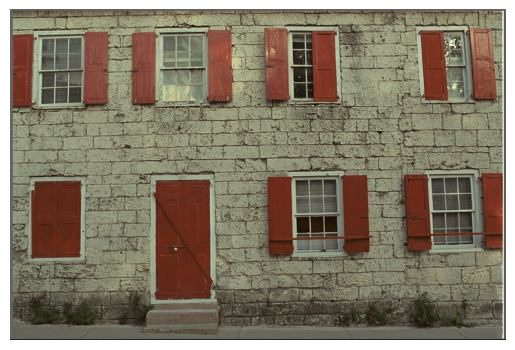

(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [3]:
image = lrf.read_image("./data/kodak/kodim01.png")
lrf.vis_image(image, save_dir=save_dir, prefix=prefix, format="pdf")

# Calculate Compression metrics

In [4]:
results = []

# JPEG
for quality in range(0, 25, 1):
    params = {"quality": quality}
    config = {"data": prefix, "method": "JPEG", **params}
    log = lrf.eval_compression(
        image,
        lrf.pil_encode,
        lrf.pil_decode,
        reconstruct=True,
        format="JPEG",
        **params,
    )
    results.append({**config, **log})

# SVD
for quality in np.linspace(0.0, 4, 25):
    params = {
        "color_space": "RGB",
        "quality": quality,
        "patch": True,
        "patch_size": (8, 8),
    }
    config = {"data": prefix, "method": "SVD", **params}
    log = lrf.eval_compression(
        image, lrf.svd_encode, lrf.svd_decode, reconstruct=True, **params
    )
    results.append({**config, **log})


# QMF
for quality in np.linspace(0, 25, 25):
    params = {
        "color_space": "YCbCr",
        "scale_factor": (0.5, 0.5),
        "quality": quality,
        "patch": True,
        "patch_size": (8, 8),
        "bounds": (-16, 15),
        "dtype": torch.int8,
        "num_iters": 10,
        "verbose": False,
    }
    config = {"data": prefix, "method": "QMF", **params}
    log = lrf.eval_compression(
        image, lrf.qmf_encode, lrf.qmf_decode, reconstruct=True, **params
    )
    results.append({**config, **log})

# Plot Metrics vs Bit Rate

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='bit rate (bpp)', ylabel='SSIM'>)

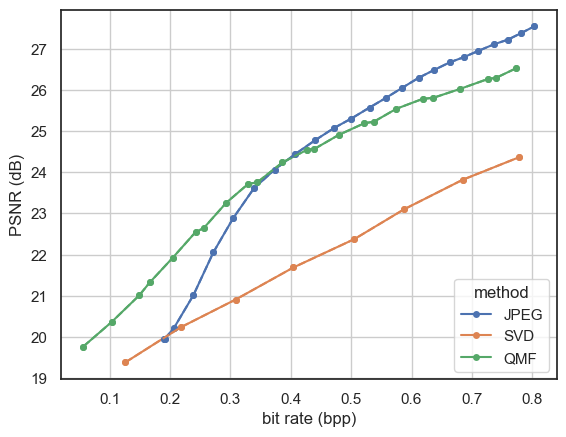

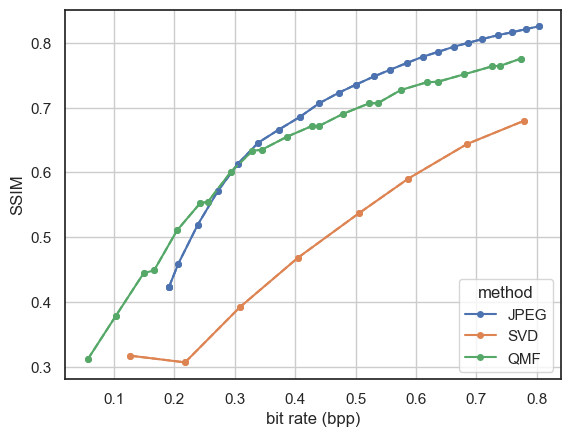

In [5]:
sns.set_theme(style="white")
plot = lrf.Plot(results, columns=("data", "method", "bit rate (bpp)", "PSNR (dB)"))
plot.plot(x="bit rate (bpp)", y="PSNR (dB)", groupby="method", errorbar=None)

plot = lrf.Plot(results, columns=("data", "method", "bit rate (bpp)", "SSIM"))
plot.plot(x="bit rate (bpp)", y="SSIM", groupby="method", errorbar=None)

# Make Qualitative Comparisons

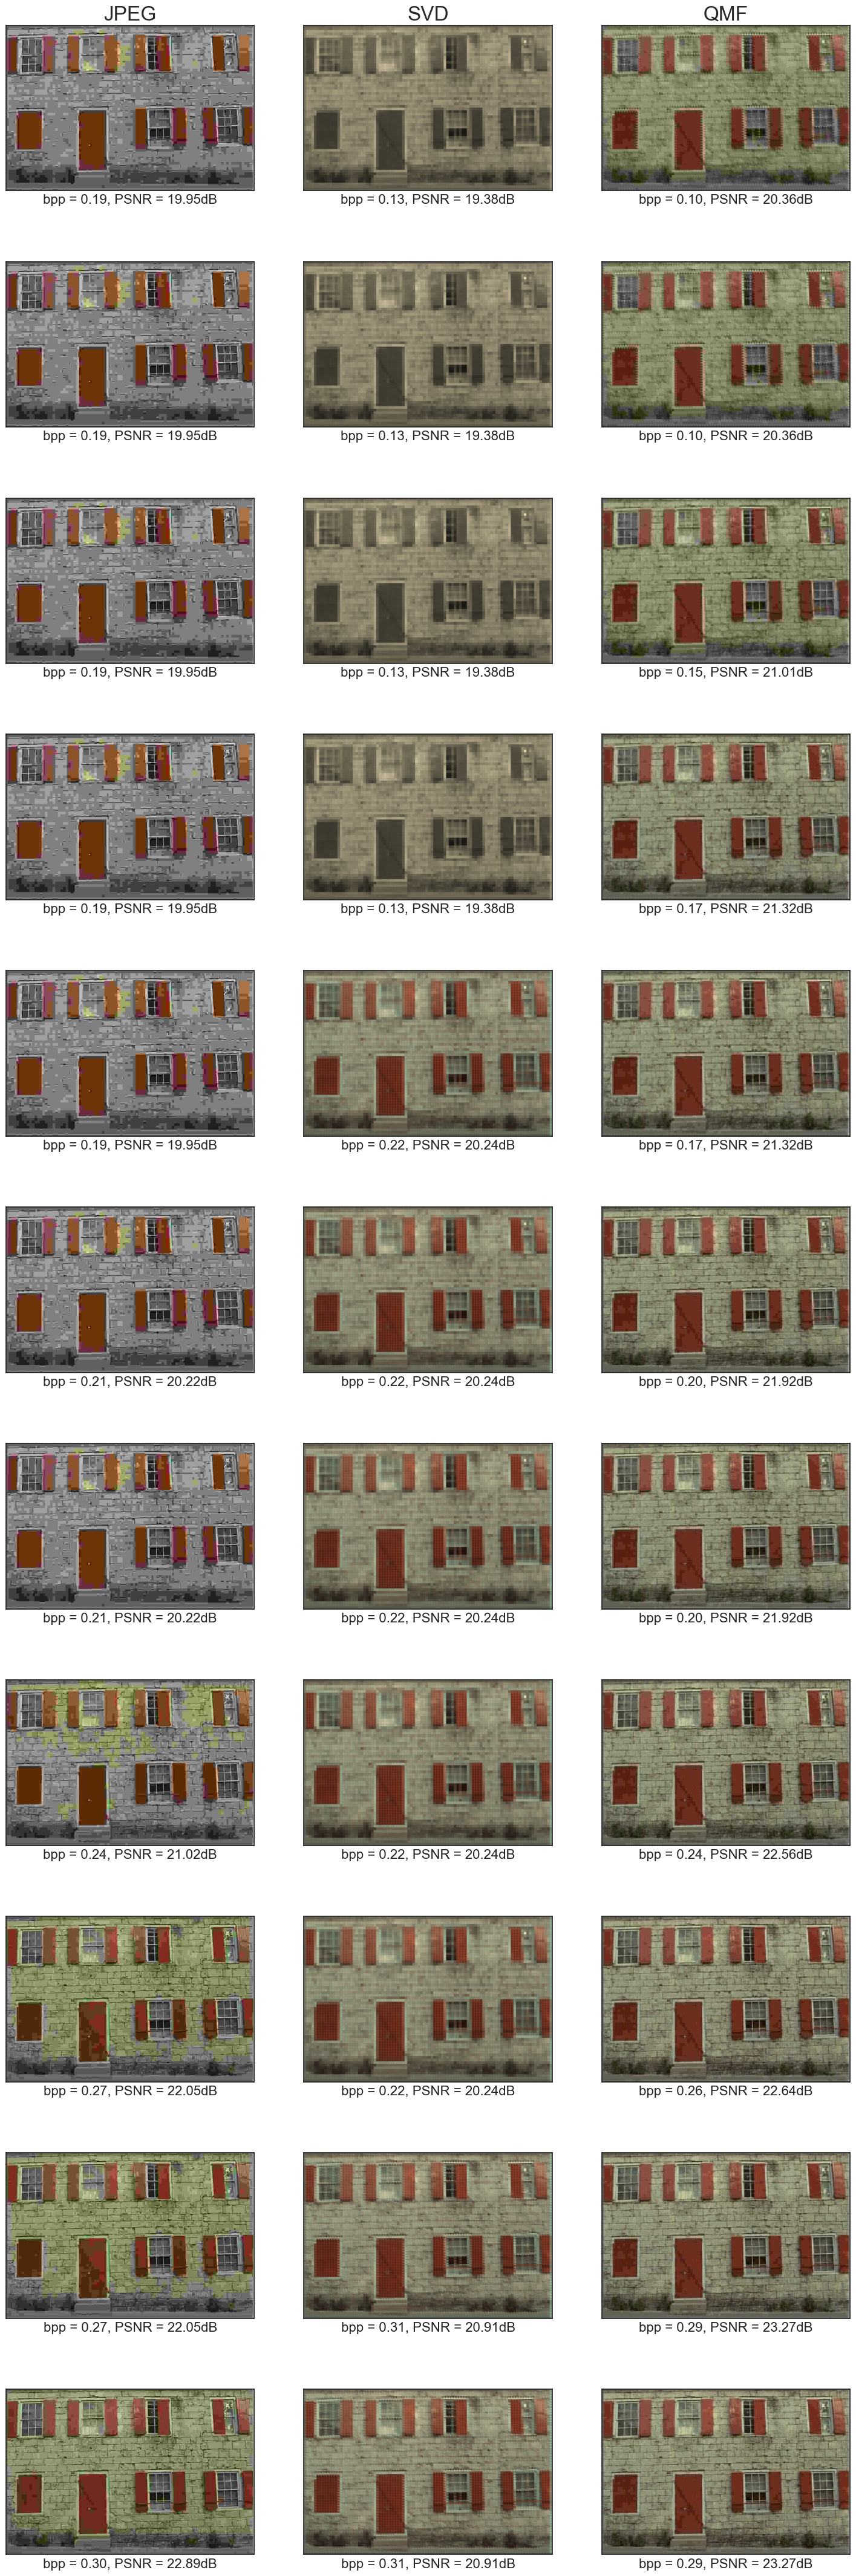

In [6]:
bpps = np.arange(.1,.31, .02)
fig, axs = lrf.vis_collage(results, bpps=bpps, save_dir=save_dir, prefix=prefix, format="pdf")

# Save Results

In [7]:
selcted_results = [
    {k: v for k, v in dc.items() if k != "reconstructed"} for dc in results
]
lrf.save_config(selcted_results, save_dir=save_dir, prefix=prefix)